In [1]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [4]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)
irisDF['dbscan_cluster'] = dbscan_labels

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

target  dbscan_cluster
0        0                49
        -1                 1
1        1                46
        -1                 4
2        1                42
        -1                 8
Name: dbscan_cluster, dtype: int64


먼저 dbscan_cluster 값을 살펴보면, 0과 1 외에 특이하게 -1이 군집 레이블로 있는 것을 알 수 있음

- **군집 레이블이 -1**인 것은 **노이즈에 속하는 군집**을 의미
- 따라서 위 붓꽃 데이터 세트는 DBSCAN에서 **0과 1 두 개의 군집**으로 군집화됐음
- Target 값 유형이 3가지인데, 군집이 2개가 됐다고 군집화 효율이 떨어진다는 의미 X
- DBSCAN은 군집의 개수를 알고리즘에 따라 자동으로 지정하므로 DBSCAN에서 군집의 개수를 지정하는 것은 무의미
- 특히 붓꽃 데이터 세트는 군집을 3개로 하는 것보다는 2개로 하는 것이 군집화의 효율로서 더 좋은 면이 있음

DBSCAN으로 군집화 데이터 세트를 2차원 평면에서 표현하기 위해 PCA를 이용해 2개의 피처로 압축 변화한 뒤, 시각화 해보자

In [6]:
def visualize_cluster_2d(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: 
        legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()

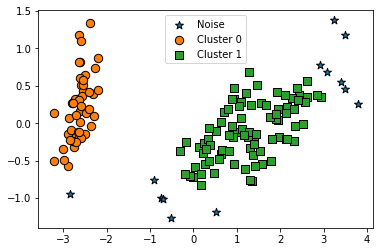

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(iris.data)

# visualize_cluster_2d() 함수는 ftr1, ftr2 칼럼을 좌표에 표현하므로
# PCA 변환값을 해당 칼럼으로 생성
irisDF['ftr1'] = pca_transformed[:, 0]
irisDF['ftr2'] = pca_transformed[:, 1]

visualize_cluster_2d(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

- 별표(★)로 표현된 값은 모두 노이즈
- PCA로 2차원으로 표현하면 이상치인 노이즈 데이터가 명확히 드러남
- DBSCAN을 적용할 때는 특정 군집 개수로 군집을 강제하지 않는 것이 좋음

    ⇒ DBSCAN 알고리즘에 적절한 eps와 min_samples 파라미터를 통해 최적의 군집을 찾는 게 중요

    - **min_samples를 크게 하면** 주어진 반경 내에 더 많은 데이터를 포함시켜야 하므로 **노이즈 데이터 개수가 커지게 됨**

        ⇒ 데이터 밀도가 커져야 하는데, **매우 촘촘한 데이터 분포가 아닌 경우 노이즈로 인식하기 때문**

- eps를 기존의 0.6에서 0.8로 증가시키면 노이즈 데이터 수가 줄어드는 것 확인

target  dbscan_cluster
0        0                50
1        1                50
2        1                47
        -1                 3
Name: dbscan_cluster, dtype: int64


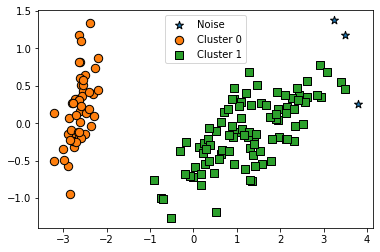

In [8]:
dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)
irisDF['dbscan_cluster'] = dbscan_labels

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_2d(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

노이즈 군집인 -1이 3개 밖에 없음

- 기존에 eps=0.6일 때 노이즈로 분류된 데이터 세트는 eps 반경이 커지면서 cluster 1에 소속됨

이번엔 eps를 기존 0.6으로 유지하고 min_samples를 16으로 늘려보자

target  dbscan_cluster
0        0                50
1        1                50
2        1                45
        -1                 5
Name: dbscan_cluster, dtype: int64


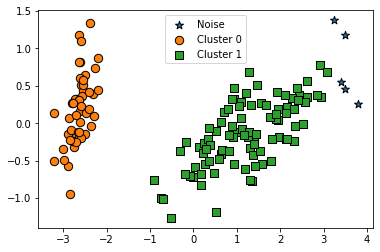

In [10]:
dbscan = DBSCAN(eps=0.8, min_samples=16, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)
irisDF['dbscan_cluster'] = dbscan_labels

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_2d(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

노이즈 데이터가 기존보다 많이 증가함을 알 수 있음